# Miles Per Gallon: TensorFlow
Here, we'll try to use TensorFlow to see if we can predict the MPG of my car
in 2016 based on the values for 2014 and 2015.

In [1]:
import tensorflow as tf
import logging

# Setup the logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

print(f'TensorFlow version: {tf.__version__}')

TensorFlow version: 2.0.0


In [2]:
# Import the rest of the modules
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd

In [3]:
# Load the data
db = pd.read_pickle('data/data_formatted.pkl')

# Extract the year and week number
db['Year'] = [date.year for date in db.Date]
db['Week'] = [date.weekofyear for date in db.Date]
db = db.drop(['Date','Price/Gal', 'Car MPG', 'paid ($)', 'Price/Barrel', 'Longitude', 'Latitude', 'Car gas', 'notes'], axis=1)
db = db.dropna(subset=['Miles', 'Real MPG'])

# Extract training and testing samples
train = db[(db.Year >= 2014) & (db.Year <= 2015)]
test  = db[(db.Year == 2016)]

# Split out the features (x) and true values (y)
train_x = train.drop(['Real MPG','Year'], axis=1)
train_y = train['Real MPG']
test_x  = test.drop(['Real MPG','Year'], axis=1)
test_y  = test['Real MPG']

train_x.describe()

,Miles,Gas Pumped,Avg Spd,Week
count,71.000000,71.000000,71.000000,71.000000
mean,483.564789,13.706310,50.135211,27.408451
std,36.190946,0.396638,5.349075,15.745818
min,392.800000,12.476000,36.400000,1.000000
25%,463.450000,13.443000,47.550000,13.500000
50%,487.900000,13.651000,49.700000,28.000000
75%,513.300000,14.026500,52.450000,41.500000
max,535.500000,14.481000,68.600000,53.000000


## Build the network
Now that we have the data, we need to build our neural network. Let's do a quick single layer model. We also don't have a tremendous amount of data, so a simple model should do.

In [4]:
nodes = 4
# Single layer TensorFlow model
layer_in = tf.keras.layers.Dense(units=nodes, 
                                 activation=tf.nn.relu,     # Input layer
                                 input_shape=[len(train_x.keys())])
layer_out = tf.keras.layers.Dense(units=1)                  # Output layer

# Assemble the model
model = tf.keras.Sequential(layers=[layer_in, layer_out])
model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.RMSprop(0.001),
              metrics=['mae','mse'])

# Print some information
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Fit the model with early stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(train_x, train_y, epochs=1000,
                    validation_split=0.2, callbacks=[early_stop])

Train on 56 samples, validate on 15 samples
Epoch 1/1000
56/56 [==============================] - 0s 6ms/sample - loss: 33.7277 - mae: 33.7277 - mse: 1145.4208 - val_loss: 30.9171 - val_mae: 30.9171 - val_mse: 964.8955
Epoch 2/1000
56/56 [==============================] - 0s 272us/sample - loss: 30.5490 - mae: 30.5490 - mse: 938.5081 - val_loss: 28.5270 - val_mae: 28.5270 - val_mse: 821.9033
Epoch 3/1000
56/56 [==============================] - 0s 179us/sample - loss: 28.3031 - mae: 28.3031 - mse: 805.8406 - val_loss: 26.5354 - val_mae: 26.5354 - val_mse: 711.5217
Epoch 4/1000
56/56 [==============================] - 0s 196us/sample - loss: 26.3971 - mae: 26.3971 - mse: 701.2717 - val_loss: 24.7494 - val_mae: 24.7494 - val_mse: 619.3139
Epoch 5/1000
56/56 [==============================] - 0s 155us/sample - loss: 24.6746 - mae: 24.6746 - mse: 612.7052 - val_loss: 23.0922 - val_mae: 23.0922 - val_mse: 539.4921
Epoch 6/1000
56/56 [==============================] - 0s 173us/sample - loss:

Now that we've trained our model, let's see if fitting it actually resulted in an improvement.

In [6]:
# Print some statistics about the history
hist = pd.DataFrame(history.history)
hist.describe()

,loss,mae,mse,val_loss,val_mae,val_mse
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,8.717416,8.717416,176.811106,7.968517,7.968517,150.352775
std,10.073991,10.073991,290.568175,9.299975,9.299975,252.223831
min,0.955747,0.955747,1.476166,0.985814,0.985814,1.512773
25%,0.979236,0.979236,1.570525,1.186514,1.186514,1.978776
50%,2.043412,2.043412,5.585007,1.385175,1.385175,2.656524
75%,15.487689,15.487689,242.457947,13.936204,13.936204,198.317970
max,33.727713,33.727715,1145.420776,30.917082,30.917082,964.895508


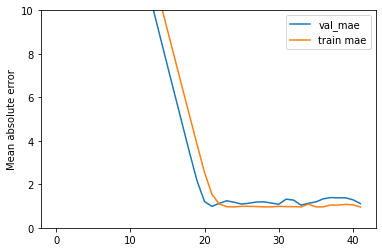

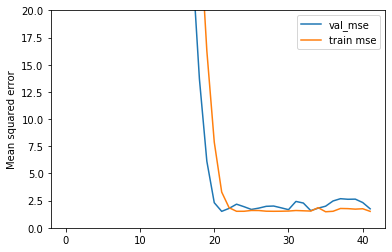

In [7]:
# Plot the learning curves for MAE
plt.figure()
plt.plot(history.epoch, hist['val_mae'], label='val_mae')
plt.plot(history.epoch, hist['mae'], label='train mae')
plt.ylabel('Mean absolute error')
leg  = plt.legend()
ylim = plt.ylim([0,10])

# Plot learning curve for MSE
plt.figure()
plt.plot(history.epoch, hist['val_mse'], label='val_mse')
plt.plot(history.epoch, hist['mse'], label='train mse')
plt.ylabel('Mean squared error')
leg = plt.legend()
ylim = plt.ylim([0,20])

Now let's see how well we do

In [8]:
# Make some predictions
loss, mae, mse = model.evaluate(test_x, test_y, verbose=0)
print('Summary statistics on testing data:')
print(f'   loss               : {loss}')
print(f'   mean squared error : {mse}')
print(f'   mean absolute error: {mae}')

Summary statistics on testing data:
   loss               : 0.9637425740559896
   mean squared error : 1.8035173416137695
   mean absolute error: 0.9637425541877747


All in all, not so terrible!

## Visualizing the predictions
Let's now make some visualizations about how well our predictions match the expected values.

In [9]:
# Get the model predictions on our test data
mpg_preds = model.predict(test_x).flatten()
mpg_preds[:10]

array([32.80453 , 33.229336, 30.696564, 33.6867  , 33.240776, 33.904816,
       35.439404, 34.96696 , 38.901756, 37.016705], dtype=float32)

Trend line : Blue
Perfect fit: Black


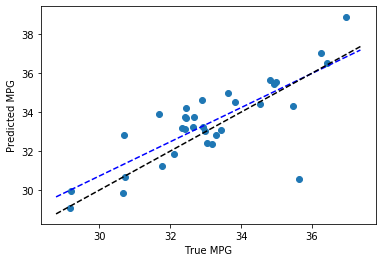

In [10]:
# Make some plots
plt.scatter(test_y, mpg_preds)
plt.xlabel('True MPG')
plt.ylabel('Predicted MPG')

# Add a trend line and best fit line
trend    = np.poly1d( np.polyfit(test_y, mpg_preds, 1) )
best_fit = np.poly1d([1,0.0])
xlim = plt.xlim()
plt.plot(xlim, trend(xlim),"b--")
plt.plot(xlim, best_fit(xlim), color='black', linestyle='--')
print('Trend line : Blue')
print('Perfect fit: Black')

Text(0.5, 0, 'Prediction - True (MPG)')

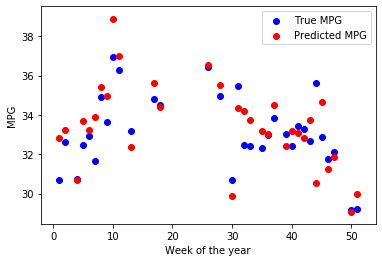

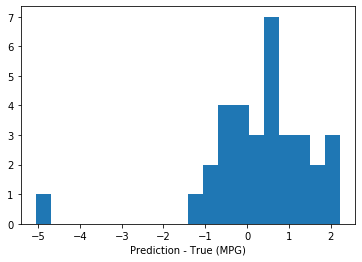

In [11]:
# Plot of MPG
plt.figure()
plt.scatter(test_x.Week, test_y, color='blue', label='True MPG')
plt.scatter(test_x.Week, mpg_preds, color='red', label='Predicted MPG')
plt.xlabel('Week of the year')
plt.ylabel('MPG')
leg = plt.legend()

# Histogram of offset
plt.figure()
error = mpg_preds - test_y
plt.hist(error, bins=20)
plt.xlabel('Prediction - True (MPG)')

Still that one point that is way out there, but we will assume that everything is more or less consistent with what we found with scikit-learn random forests.